# 이상치 탐지

- 이상치 : 노출 시간도 높고, 취급액도 높은 데이터들.
- 판매단가는 이상치에 거의 영향이 없다.
- 노출 시간에 영향을 미치는 내부 변수, 외부 변수를 찾아 보자.

In [1]:
# module import
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
warnings.filterwarnings(action='ignore')

In [4]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [5]:
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

# 사전 작업

In [6]:
# 경로 설정
root_path = "/content/drive/My Drive/Big-Contest"
data_path = f"{root_path}/data"

# SALES_DATA = f"{data_path}/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터.xlsx"
SALES_FULL_DATA = f"{data_path}/2019년실적.xlsx"
RATINGS_DATA = f"{data_path}/2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx"

In [7]:
# 데이터 로드
raw_data = pd.read_excel(SALES_FULL_DATA, parse_dates=True, usecols=lambda x: 'Unnamed' not in x)
display(raw_data)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,20.000000,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0
2,2019-01-01 06:20:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0
3,2019-01-01 06:20:00,20.000000,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0
4,2019-01-01 06:40:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0
...,...,...,...,...,...,...,...,...
38304,2020-01-01 00:20:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38305,2020-01-01 00:40:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38306,2020-01-01 01:00:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38307,2020-01-01 01:20:00,20.000000,100490,201478,더케이 예다함 상조서비스(티포트),무형,0,NaN


In [8]:
# 원본 데이터 보존
data = raw_data.copy()
data.head(3)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0


In [9]:
data.info() # 취급액 결측치

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38309 entries, 0 to 38308
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    38309 non-null  datetime64[ns]
 1   노출(분)   38309 non-null  float64       
 2   마더코드    38309 non-null  int64         
 3   상품코드    38309 non-null  int64         
 4   상품명     38309 non-null  object        
 5   상품군     38309 non-null  object        
 6   판매단가    38309 non-null  int64         
 7   취급액     37372 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.3+ MB


In [10]:
# 결측치: 취급액이 NaN인 것
print(data.isnull().sum())
print(data[data['취급액'].isnull()]['상품군'].unique())

방송일시       0
노출(분)      0
마더코드       0
상품코드       0
상품명        0
상품군        0
판매단가       0
취급액      937
dtype: int64
['무형']


In [11]:
# 취급액 0인 상품 제외
data = data.dropna()
data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37372 entries, 0 to 38303
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    37372 non-null  datetime64[ns]
 1   노출(분)   37372 non-null  float64       
 2   마더코드    37372 non-null  int64         
 3   상품코드    37372 non-null  int64         
 4   상품명     37372 non-null  object        
 5   상품군     37372 non-null  object        
 6   판매단가    37372 non-null  int64         
 7   취급액     37372 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.6+ MB


컬럼 타입 변경, 컬럼 추가/삭제 등

In [13]:
# 컬럼 타입 변경
data['마더코드'] = data['마더코드'].astype(str)
data['상품코드'] = data['상품코드'].astype(str)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37372 entries, 0 to 38303
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   방송일시    37372 non-null  datetime64[ns]
 1   노출(분)   37372 non-null  float64       
 2   마더코드    37372 non-null  object        
 3   상품코드    37372 non-null  object        
 4   상품명     37372 non-null  object        
 5   상품군     37372 non-null  object        
 6   판매단가    37372 non-null  int64         
 7   취급액     37372 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 2.6+ MB


In [14]:
# 방송 년, 월
data = data.assign(Date=data['방송일시'].dt.date, Time=data['방송일시'].dt.time)
data['year_month'] = pd.to_datetime(data['Date']).dt.year*100 + pd.to_datetime(data['Date']).dt.month
data['year_month'] = data['year_month'].astype(str)
data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,Date,Time,year_month
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01,06:00:00,201901
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01,06:00:00,201901
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019-01-01,06:20:00,201901
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019-01-01,06:20:00,201901
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019-01-01,06:40:00,201901


In [15]:
# 방송 계절
def map_season(x):
    if x[-2:] in ['03', '04', '05']:
        return '봄'
    elif x[-2:] in ['06', '07', '08']:
        return '여름'
    elif x[-2:] in ['09', '10', '11']:
        return '가을'
    else:
        return '겨울'

data['season'] = data['year_month'].apply(lambda x: map_season(x))
data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,Date,Time,year_month,season
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01,06:00:00,201901,겨울
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01,06:00:00,201901,겨울
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019-01-01,06:20:00,201901,겨울
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019-01-01,06:20:00,201901,겨울
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019-01-01,06:40:00,201901,겨울


In [16]:
# 방송 요일
data['weekday'] = data['방송일시'].dt.day_name()
data.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,Date,Time,year_month,season,weekday
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01,06:00:00,201901,겨울,Tuesday
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01,06:00:00,201901,겨울,Tuesday
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019-01-01,06:20:00,201901,겨울,Tuesday
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019-01-01,06:20:00,201901,겨울,Tuesday
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019-01-01,06:40:00,201901,겨울,Tuesday


In [17]:
# 원본 데이터 보존
df = data[['Date', 'Time', 'year_month', 'season', 'weekday', '노출(분)', '상품군', '마더코드', '상품코드', '상품명', '판매단가', '취급액']]
df.head()

,Date,Time,year_month,season,weekday,노출(분),상품군,마더코드,상품코드,상품명,판매단가,취급액
0,2019-01-01,06:00:00,201901,겨울,Tuesday,20.0,의류,100346,201072,테이트 남성 셀린니트3종,39900,2099000.0
1,2019-01-01,06:00:00,201901,겨울,Tuesday,20.0,의류,100346,201079,테이트 여성 셀린니트3종,39900,4371000.0
2,2019-01-01,06:20:00,201901,겨울,Tuesday,20.0,의류,100346,201072,테이트 남성 셀린니트3종,39900,3262000.0
3,2019-01-01,06:20:00,201901,겨울,Tuesday,20.0,의류,100346,201079,테이트 여성 셀린니트3종,39900,6955000.0
4,2019-01-01,06:40:00,201901,겨울,Tuesday,20.0,의류,100346,201072,테이트 남성 셀린니트3종,39900,6672000.0


# Isolation Forest


In [18]:
# module import
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [19]:
def scale_data(data, scaler, plot=True):
    scaler = scaler()
    scaler.fit(data.values)
    data_scaled = scaler.transform(data.values)
    print(data_scaled)
    
    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(data_scaled[:, 0], data_scaled[:, 1])
        plt.show()
    
    return data_scaled

In [29]:
def check_anomalies_2d(data, ratio, plot=True):
    clf = IsolationForest(n_estimators=100, max_samples=100, contamination=ratio)
    clf.fit(data)
    pred = clf.predict(data)
    df_grouped['outlier'] = pred
    
    outs = df_grouped[df_grouped['outlier'] == -1]
    normals = df_grouped[df_grouped['outlier'] == 1]

    # 이상치 확인
    display(outs)

    # 시각화
    plt.figure(figsize=(8, 6))
    plt.scatter(outs.values[:, 0], outs.values[:, 1], color='red', label='Outlier')
    plt.scatter(normals.values[:, 0], normals.values[:, 1], color='blue', alpha=0.3, label='Normal')
    plt.show()

    return outs.index

In [21]:
def check_anomalies_3d(data, ratio, plot3d=True, plot2d=False, labels=None):
    print(f"\n=============== {ratio} =================")
    clf = IsolationForest(n_estimators=100, max_samples=100, contamination=ratio)
    clf.fit(data)
    pred = clf.predict(data)
    X_data['outlier'] = pred
    
    outs = X_data[X_data['outlier'] == -1]
    normals = X_data[X_data['outlier'] == 1]

    # 이상치 확인
    # display(outs)

    # 시각화
    if plot3d:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.gca(projection='3d')
        ax.scatter(outs.values[:, 0], outs.values[:, 1], outs.values[:, 2], color='red', label='Outlier')
        ax.scatter(normals.values[:, 0], normals.values[:, 1], normals.values[:, 2], color='blue', alpha=0.3, label='Normal')
        plt.show()
    
    if plot2d:
        label=labels
        fig = plt.figure(figsize=(24, 6))
        ax1, ax2, ax3 = fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)

        ax1.scatter(outs.values[:, 0], outs.values[:, 1], color='red', label='Outlier')
        ax1.scatter(normals.values[:, 0], normals.values[:, 1], color='blue', alpha=0.3, label='Normal')
        ax1.set_xlabel(label[0])
        ax1.set_ylabel(label[1])

        ax2.scatter(outs.values[:, 1], outs.values[:, 2], color='red', label='Outlier')
        ax2.scatter(normals.values[:, 1], normals.values[:, 2], color='blue', alpha=0.3, label='Normal')
        ax2.set_xlabel(label[1])
        ax2.set_ylabel(label[2])

        ax3.scatter(outs.values[:, 2], outs.values[:, 0], color='red', label='Outlier')
        ax3.scatter(normals.values[:, 2], normals.values[:, 0], color='blue', alpha=0.3, label='Normal')        
        ax3.set_xlabel(label[2])
        ax3.set_xlabel(label[0])
        
        plt.show()

    return outs.index

## _1_. 방송횟수, 취급액 합

In [22]:
df_grouped = df.groupby(by=['상품명', '상품군']).agg({'Date':['count'],
                                              '취급액':['sum']})
display(df_grouped)

,,Date,취급액
,,count,sum
상품명,상품군,,
뉴트리원 다이어트 구미,건강기능,60,2.389359e+09
[가이거] 블랙 에디션 다이아몬드 워치(남성용),잡화,3,3.290400e+07
[가이거] 블랙 에디션 다이아몬드 워치(여성용),잡화,3,4.612100e+07
[맛있는 제주]손질 생선 3대세트+흑돼지구이(광어+갈치+고등어,농수축,3,2.763200e+07
국내제조 오슬로 IH 프라이팬 세트,주방,12,3.632050e+08
...,...,...,...
효재 화원 자수 광목워싱 침구세트 슈퍼싱글,침구,6,1.676700e+07
효재 화원 자수 광목워싱 침구세트 퀸,침구,6,2.961700e+07


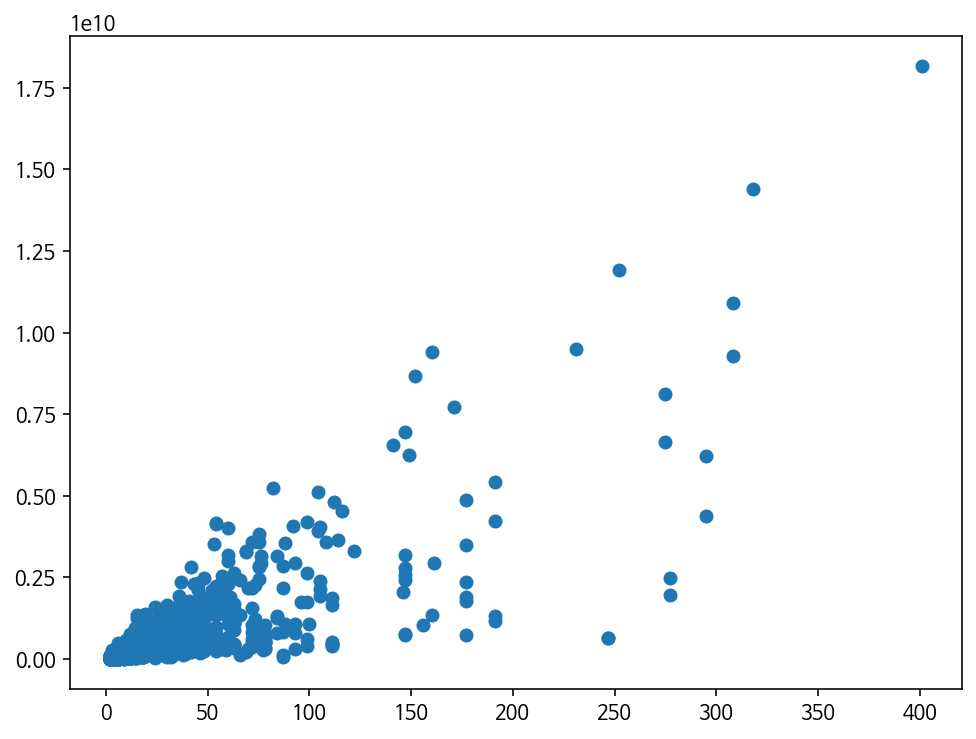

In [23]:
# 기존 데이터 분포
plt.figure(figsize=(8, 6))
plt.scatter(df_grouped.values[:, 0], df_grouped.values[:, 1])
plt.show()

[[ 1.02887507  1.67623328]
 [-0.51799821 -0.39582965]
 [-0.51799821 -0.38420777]
 ...
 [-0.43658383 -0.36626977]
 [ 0.62180315  0.66219125]
 [ 0.62180315  0.22408204]]


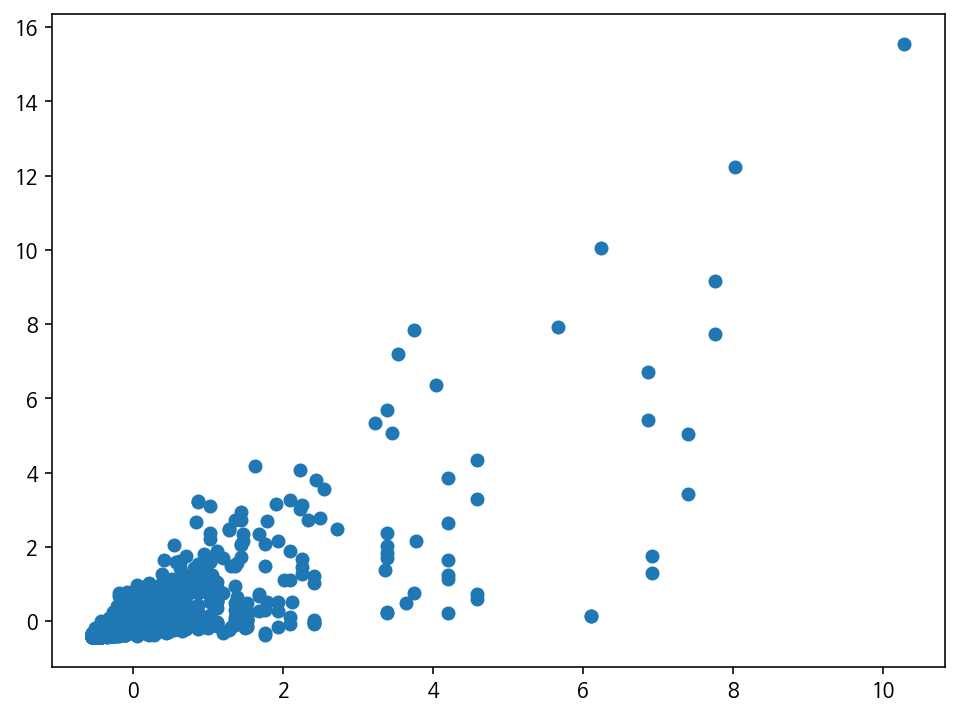

In [24]:
# Standard Scaling
X_std_scaled = scale_data(df_grouped, StandardScaler)

[[ 1.44847551  1.87718229]
 [-1.23189151 -0.81395863]
 [-1.23189151 -0.65301962]
 ...
 [-0.47074077 -0.47009513]
 [ 1.26860051  1.35736036]
 [ 1.26860051  0.98103101]]


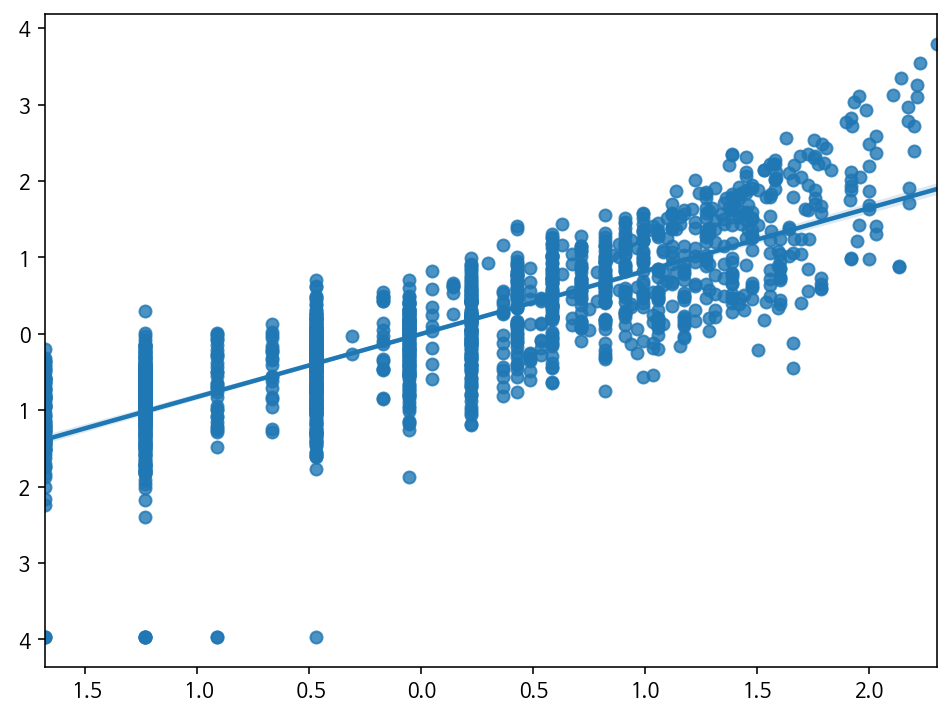

In [26]:
# boxcox scale
X_pt_scaled = scale_data(df_grouped, PowerTransformer, plot=False)

plt.figure(figsize=(8, 6))
sns.regplot(x=X_pt_scaled[:, 0],
            y=X_pt_scaled[:, 1],
            fit_reg=True)
plt.show()

,,Date,취급액,outlier
,,count,sum,
상품명,상품군,,,
AAB의 소곱창전골 800g x 8팩,농수축,252,1.192397e+10,-1
국내산 손질갑오징어 8팩,농수축,160,9.417609e+09,-1
멋진밥상 흥양농협 쌀 20kg,농수축,171,7.733978e+09,-1
무이자 LG 울트라HD TV 65UK6800HNC,가전,295,4.392654e+09,-1
무이자 LG 통돌이 세탁기,가전,275,6.658529e+09,-1
무이자 LG전자 매직스페이스 냉장고,가전,308,9.278839e+09,-1
무이자 쿠쿠전기밥솥 10인용(CRP-QS107FG/FS),주방,191,5.426975e+09,-1
비버리힐스폴로클럽 남성기초세트(골드+콜라겐),이미용,152,8.682518e+09,-1


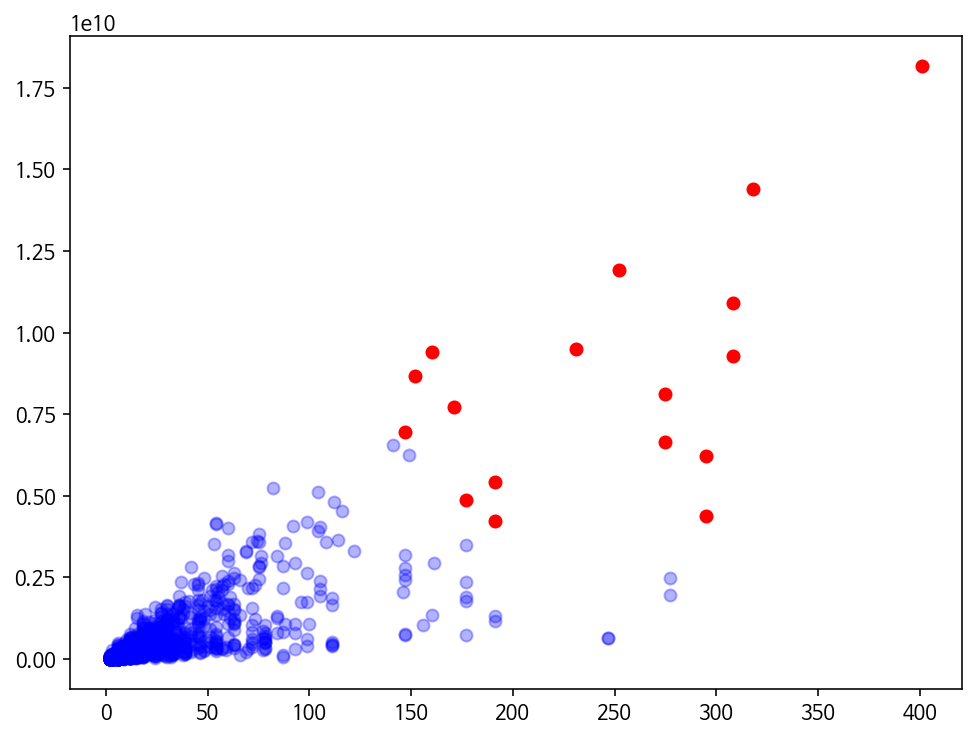

In [30]:
# Standard Scaled 데이터에 대해 이상치 확인
ratios = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]
for ratio in ratios:
    check_anomalies_2d(X_std_scaled, ratio)
    break

,,Date,취급액,outlier
,,count,sum,
상품명,상품군,,,
(일)한샘 하이바스 내추럴 기본형 + 키큰장,가구,2,0.000000e+00,-1
(일)한샘 하이바스 내추럴 하부장 + 키큰장,가구,2,0.000000e+00,-1
(일)한샘 하이바스 내추럴 하부장형,가구,2,0.000000e+00,-1
AAB의 소곱창전골 800g x 8팩,농수축,252,1.192397e+10,-1
국내산 손질갑오징어 8팩,농수축,160,9.417609e+09,-1
멋진밥상 흥양농협 쌀 20kg,농수축,171,7.733978e+09,-1
무이자 LG 울트라HD TV 65UK6800HNC,가전,295,4.392654e+09,-1
무이자 LG 통돌이 세탁기,가전,275,6.658529e+09,-1


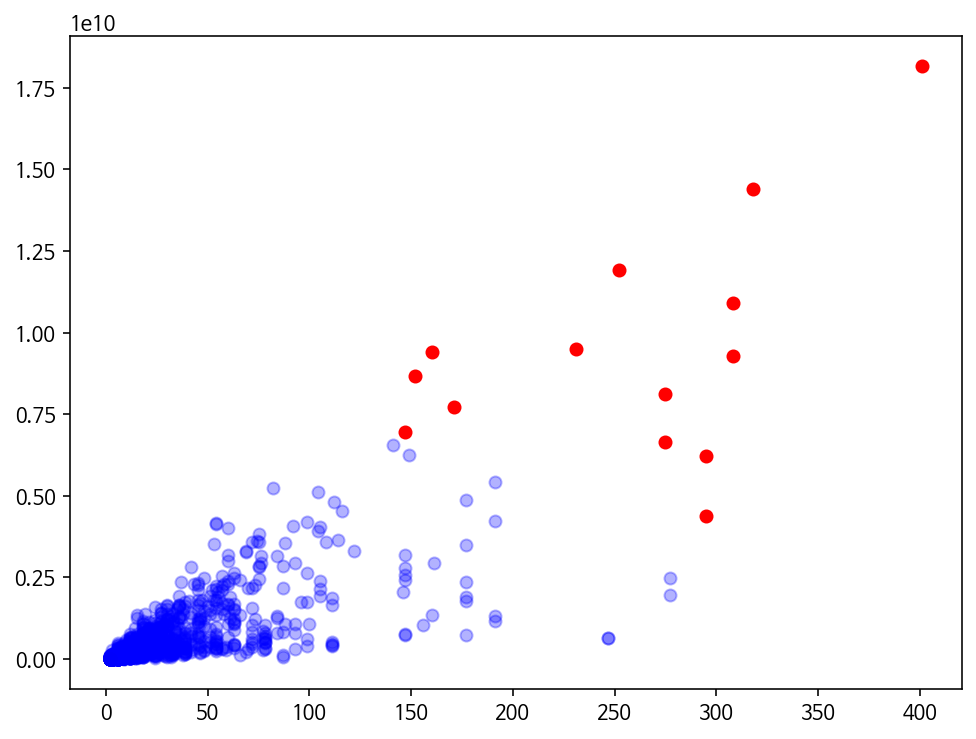

In [31]:
# PowerTransformed 데이터에 대해 이상치 확인
ratios = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]
for ratio in ratios:
    check_anomalies_2d(X_pt_scaled, ratio)
    break

## _2_. 노출 합계, 판매단가 평균, 취급액 합계

- 0.02, 0.03 정도로 이상치 빼 보고 군집 분석에 연결.

In [32]:
df_grouped = data.groupby(by=['상품명', '상품군', '마더코드', '상품코드'], as_index=False).agg({'노출(분)':['sum'],
                                                                                  '판매단가':['mean'],
                                                                                  '취급액':['sum']})
df_grouped.columns = ['상품명', '상품군', '마더코드', '상품코드', '노출(분)', '판매단가', '취급액']
df_grouped['노출(분)'] = round(df_grouped['노출(분)'], 1)
df_grouped.head(3)

,상품명,상품군,마더코드,상품코드,노출(분),판매단가,취급액
0,뉴트리원 다이어트 구미,건강기능,100055,200139,1200.0,59000.0,2.389359e+09
1,[가이거] 블랙 에디션 다이아몬드 워치(남성용),잡화,100292,200942,60.0,178000.0,3.290400e+07
2,[가이거] 블랙 에디션 다이아몬드 워치(여성용),잡화,100292,200943,60.0,178000.0,4.612100e+07


In [35]:
# 사용할 데이터
X_data = df_grouped[['노출(분)', '판매단가', '취급액']]
X_data.head(3)

,노출(분),판매단가,취급액
0,1200.0,59000.0,2.389359e+09
1,60.0,178000.0,3.290400e+07
2,60.0,178000.0,4.612100e+07


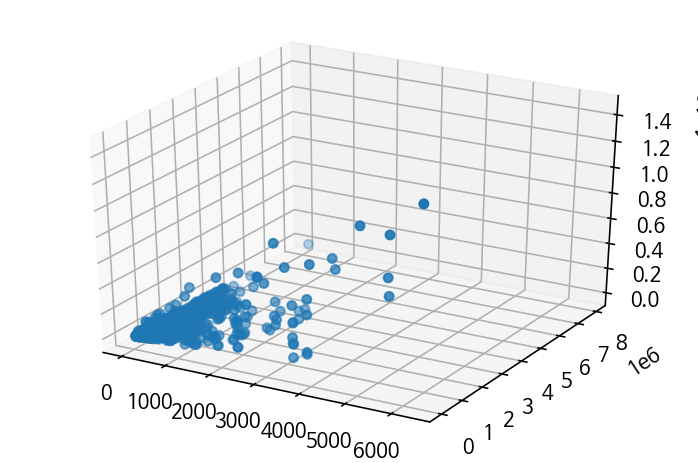

<Figure size 576x432 with 0 Axes>

In [36]:
# 기존 데이터 분포
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.figure(figsize=(8, 6))
ax.scatter(X_data.values[:, 0], X_data.values[:, 1], X_data.values[:, 2])
plt.show()

[[ 1.45356163 -0.49147061  2.13092707]
 [-0.5502914  -0.33217184 -0.39355519]
 [-0.5502914  -0.33217184 -0.37939575]
 ...
 [ 0.81584419 -0.47687938  0.83334305]
 [-0.5502914  -0.50365228 -0.38795977]
 [ 0.81584419 -0.47687938  0.3208639 ]]


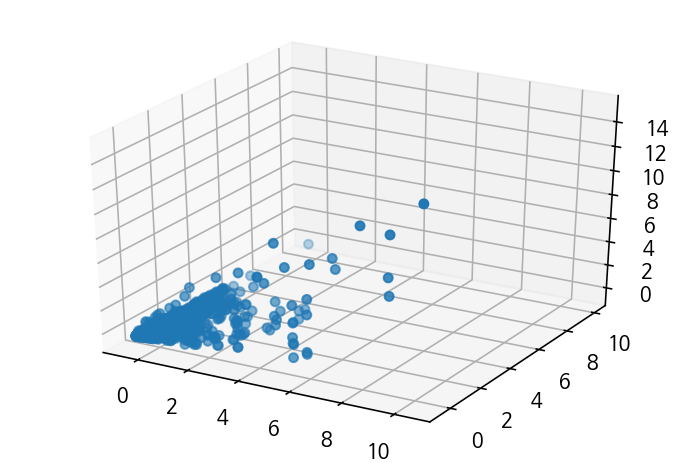

<Figure size 576x432 with 0 Axes>

In [37]:
# Standard Scaling
X_std_scaled = scale_data(X_data, StandardScaler, plot=False)

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.figure(figsize=(8, 6))
ax.scatter(X_std_scaled[:, 0], X_std_scaled[:, 1], X_std_scaled[:, 2])
plt.show()


=============== 0.01 =================


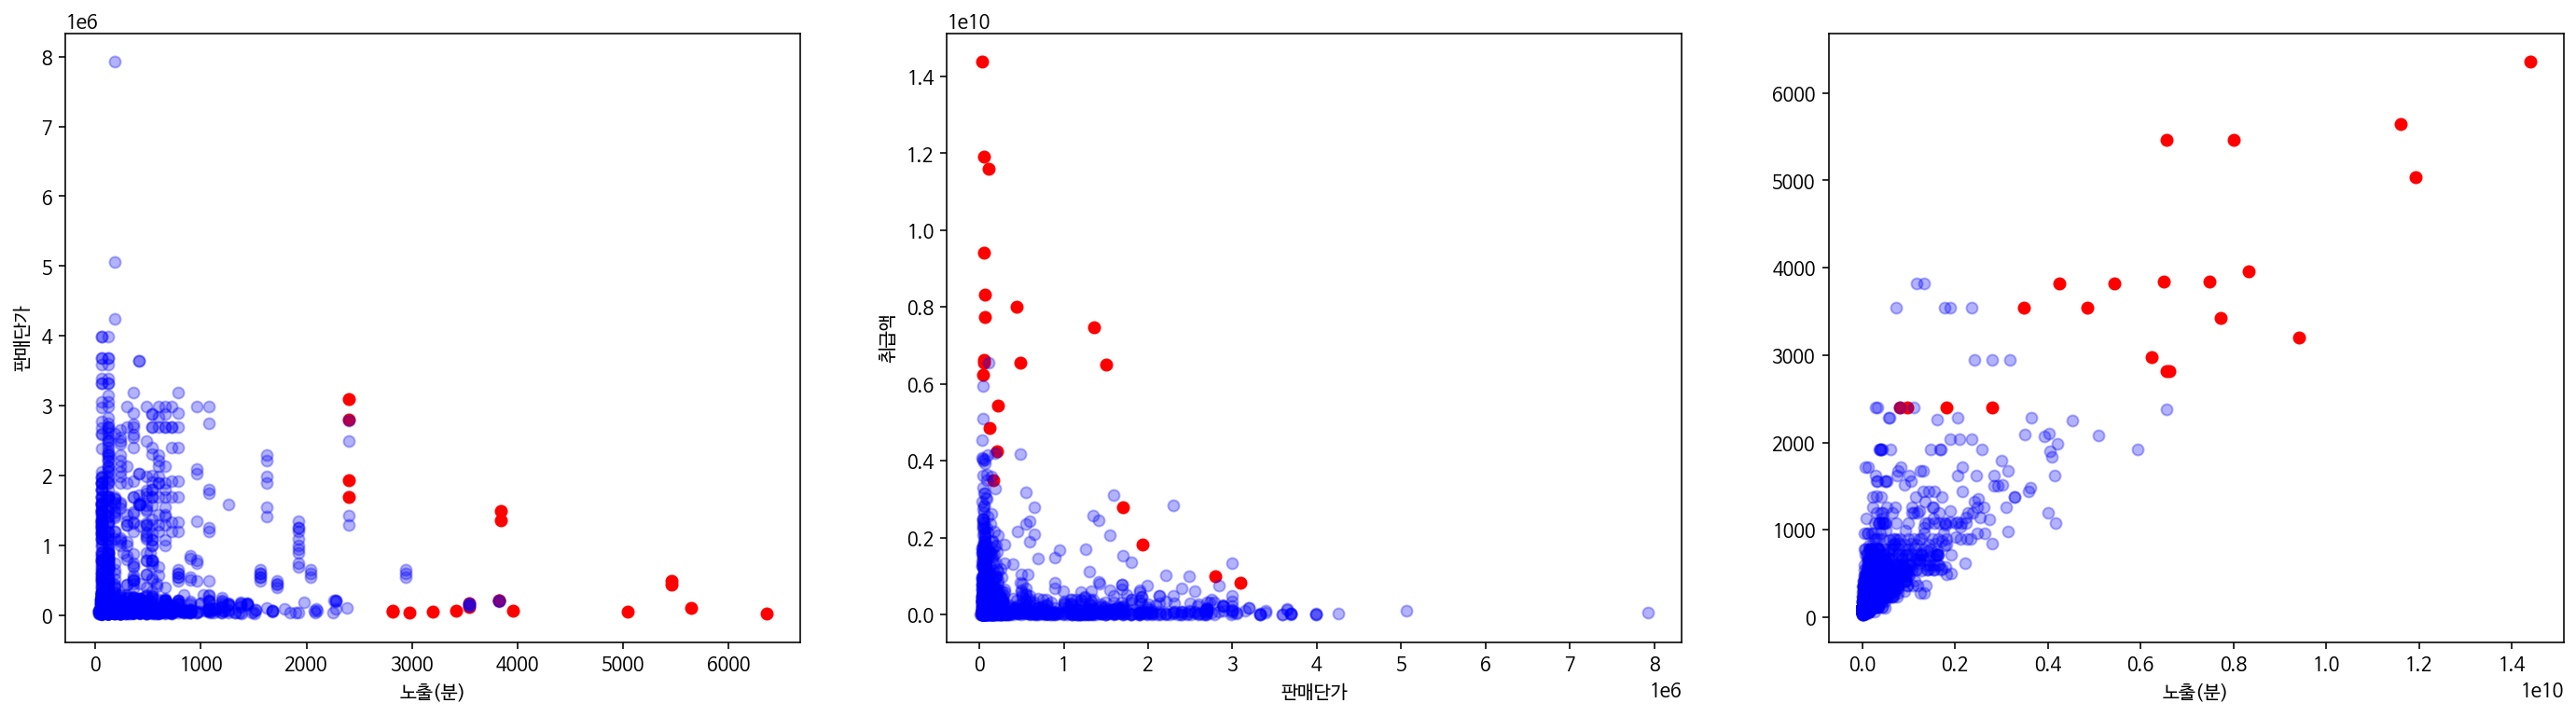

In [39]:
# Standard Scaled 데이터에 대해 이상치 확인
ratios = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]
labels = X_data.columns.tolist()
for ratio in ratios:
    check_anomalies_3d(X_std_scaled, ratio, plot3d=False, plot2d=True, labels=labels)
    break


=============== 0.01 =================


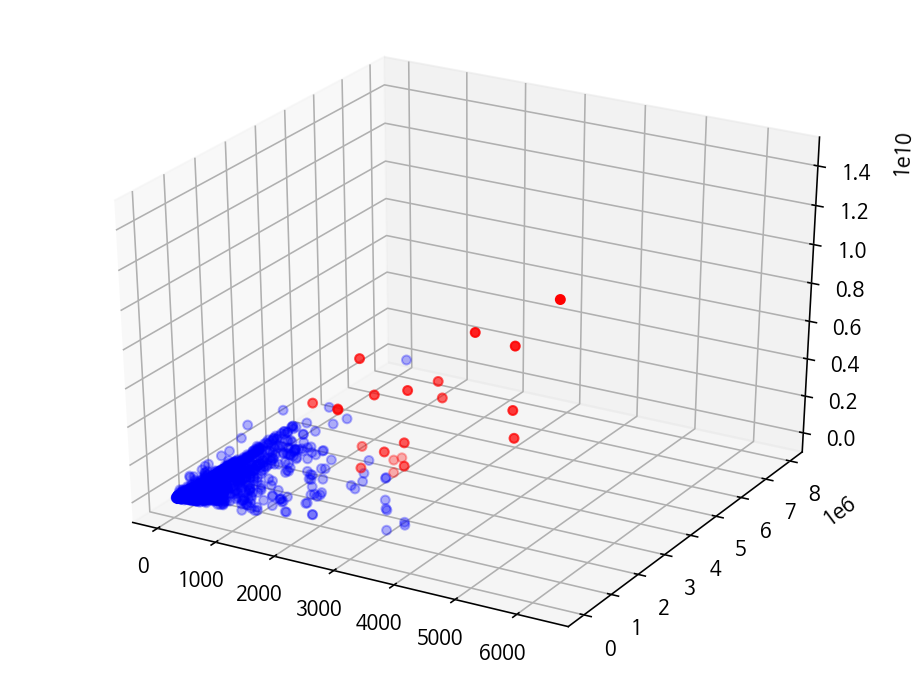

In [38]:
# Standard Scaled 데이터에 대해 이상치 확인: 3차원 plot
ratios = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]
for ratio in ratios:
    check_anomalies_3d(X_std_scaled, ratio)
    break

In [ ]:
# 태엽에게 전달할 인덱스
indices = {}
for ratio in [0.02, 0.03]:
    abnormals = check_anomalies_3d(X_data, ratio, plot=False)
    indices[ratio] = abnormals.tolist()
print(indices)